@software{Alireza_Soroudi_PyomoOptimization,
author = {Alireza Soroudi, Alireza},
license = {MIT},
title = {{PyomoOptimization}},
url = {https://github.com/OptimizationExpert/Pyomo}
}

The required packages are imported 

In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import math

The sample input data is generated in this cell

In [2]:
seven_seen_collection = {1:'Sib (Apple)', 2:'Serkeh (Vinegar)', 3:'Sekkeh (Coin)', 4:'Sabzeh (grass)',
                         5:'Sumac', 6:'Sir (Garlic)', 7:'Senjed (Elaeagnus)', 8:'Samanu (Sprout Wheat )',
                         9:'Sonbol (Hyacinth)' , 10:'Mirror', 11:'Shahnameh', 12:'Red fish'}

In [3]:
n = 0
location = {}
for i in range(1,6):
    for j in range(1,6):
        n+=1
        location[n]=(i,j) 
N=n
distance = {}
for n1 in range(1,N+1):
    for n2 in range(1,N+1):
        distance[n1,n2] = sqrt(  (location[n1][0]-location[n2][0])**2 + (location[n1][1]-location[n2][1])**2  )

In [4]:
model = AbstractModel()
model.i = RangeSet(len(seven_seen_collection))
model.j = Set(initialize= model.i)
model.n = RangeSet(N)

model.U = Var(model.i, initialize = 0, within=Binary)
model.P = Var(model.n, initialize = 0, within=Binary)
model.link = Var(model.i,model.n, initialize = 0, within=Binary)

model.z = Var(model.n, model.n, initialize = 0, bounds=(0,1), within=Reals)
def Rule_C_7seens(model):
    return sum(model.U[i] for i in model.i if i<= 9) == 7
model.C1=Constraint(rule=Rule_C_7seens)

def Rule_C_additional(model):
    return sum(model.U[i] for i in model.i if i> 9) >= 1
model.C2=Constraint(rule=Rule_C_additional)

def Rule_C3(model,n1,n2):
    if n1>n2:
        return model.z[n1,n2] >= model.P[n1] +model.P[n2]-1
    else:
        return Constraint.Skip 
model.C3=Constraint(model.n, model.n, rule=Rule_C3)

def Rule_C4(model,n1,n2):
    if n1>n2:
        return model.z[n1,n2] <= model.P[n1]
    else:
        return Constraint.Skip 
model.C4=Constraint(model.n, model.n, rule=Rule_C4)

def Rule_C5(model,n1,n2):
    if n1>n2:
        return model.z[n1,n2] <= model.P[n2]
    else:
        return Constraint.Skip 
model.C5=Constraint(model.n, model.n, rule=Rule_C5)

def Rule_C6(model,i):
    return model.U[i]  == sum(model.link[i,n] for n in model.n) 
model.C6=Constraint(model.i, rule=Rule_C6)

def Rule_C7(model,n):
    return model.P[n]  == sum(model.link[i,n] for i in model.i) 
model.C7=Constraint(model.n, rule=Rule_C7)

def rule_OF(model):
    return sum(distance[n1,n2]*model.z[n1,n2] for n1 in model.n for n2 in model.n if n1>n2)
model.obj = Objective(rule=rule_OF, sense=maximize)

In [5]:
"""
create an instance of the model
"""
instance = model.create_instance()  

In [6]:
from pyomo import environ as pe
import os
os.environ['NEOS_EMAIL'] = 'x@gmail.com' 
opt = pe.SolverManagerFactory('neos')
results = opt.solve(instance, solver = "cplex")
print(value(instance.obj))

155.43156925734772


In [7]:
for i in instance.i:
    for n in instance.n:
        if value(instance.link[i,n])>0:
            print((i,n) , value(instance.link[i,n]))

(1, 20) 1.0
(2, 6) 1.0
(4, 4) 1.0
(5, 5) 1.0
(7, 24) 1.0
(8, 25) 1.0
(9, 2) 1.0
(10, 22) 1.0
(11, 1) 1.0
(12, 21) 1.0


This is used for visualization of teh results 
which class will have the exam and when 

12


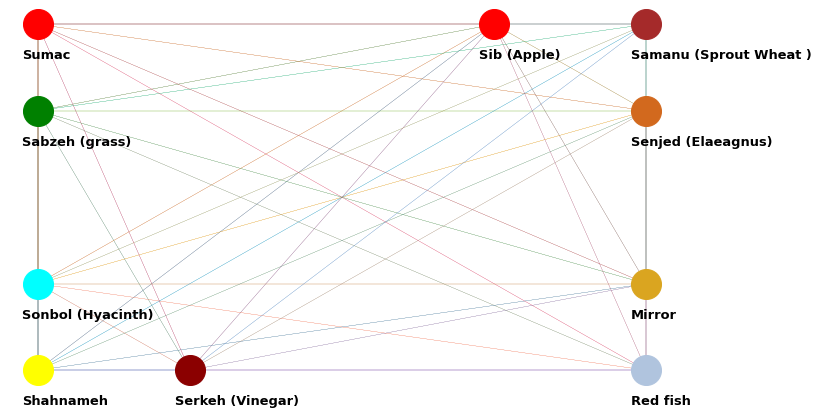

In [8]:
                                        
KOLOR = ['r', 'darkred', 'gold', 'g', 'r', 'grey','chocolate','brown','aqua','goldenrod','yellow','lightsteelblue' ]
print(len(KOLOR))
kvec = []
dvec = []
plt.figure(figsize=(12,7))

for n in instance.n:
    for i in instance.i:
        if value(instance.link[i,n])>0:
            x0, y0  = location[n][0],location[n][1] 
            plt.scatter(x0,y0,c=KOLOR[i-1],s=900, zorder =2)
            plt.text(x0-0.1,y0-0.4,s=seven_seen_collection[i], zorder =2,fontsize=13, fontweight='bold')
            
plt.grid()
plt.axis('off')

for n1 in instance.n:
    for n2 in instance.n:
        if value(instance.P[n1]*instance.P[n2])>0:
            x0, y0  = location[n1][0],location[n1][1] 
            x1, y1  = location[n2][0],location[n2][1]
            plt.plot([x0,x1],[y0,y1], lw=0.2 , zorder= -1)
plt.savefig('max7seen'+  ' .png', format='png', dpi=400)